In [1]:
import pickle, h5py, itertools, warnings, os
from pathlib import Path
from tqdm.auto import tqdm, trange

from sklearn.neighbors import NearestNeighbors, KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_1samp, ttest_rel, chi2, mannwhitneyu, levene
import numpy as np, pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
!ls /work/magroup/hanzhan4/model_output/hcformer_pbulk
path2figdir = Path('../figures-gage-seq-mBC')
!ls ../figures-gage-seq-mBC

baseline  hic1d2d  test_expression.pkl	 valid_expression.pkl
hic1d	  hic2d    train_expression.pkl
gradient_featvar_box.pdf
gradient_gradnorm_comparison_bar.pdf
gradient_importance_genome_ab_agg_bar.pdf
gradient_importance_genome_ab_bar.pdf
gradient_importance_genome_gb_agg_bar.pdf
gradient_importance_genome_gb_bar.pdf
gradient_importance_genome_is_agg_bar.pdf
gradient_importance_genome_is_bar.pdf
gradient_importance_genome_seq_agg_bar.pdf
gradient_importance_genome_seq_bar.pdf
gradient_nenhancer_majortype_scatter.pdf
gradient_tfbs_majortype_scatter.pdf
gradient_variance_kde_AB.pdf
gradient_variance_kde_Genebody-score.pdf
gradient_variance_kde_Insulation-score---100kb.pdf
gradient_variance_kde_Insulation-score---200kb.pdf
gradient_variance_kde_Insulation-score---50kb.pdf
performance_comparison_bar_pearson.pdf
performance_comparison_scatter_majortype_mse.pdf
performance_comparison_scatter_mse.pdf
performance_comparison_scatter_pearson.pdf
performance_explanation_box_deg.pdf
performance_

In [3]:
df_gene_id_conversion = pd.read_csv(
    '/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/gene_id_conversion.tsv',
    usecols=[0, 1], header=None, sep='\t',
).rename(columns={0: 'gene_id', 1: 'gene_name'})
df_gene_id_conversion

,gene_id,gene_name
0,ENSMUSG00000000001,Gnai3
1,ENSMUSG00000000028,Cdc45
2,ENSMUSG00000000031,H19
3,ENSMUSG00000000037,Scml2
4,ENSMUSG00000000049,Apoh
...,...,...
26414,ENSMUSG00000118642,CT010467.2
26415,ENSMUSG00000118643,AC163703.1
26416,ENSMUSG00000118651,CT030740.1
26417,ENSMUSG00000118652,AL645799.1


In [4]:
path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC')

feat_1d_list = ['ab', 'is-hw25', 'is-hw50', 'is-hw100', 'genebody']
hic_1d_all = []
for feat_name in tqdm(feat_1d_list):
    with open(path2dir / f'1d-score-celltypebulk-10kb-{feat_name}_1024_200_uint8.pkl', 'rb') as f:
        hic_1d_all.append(pickle.load(f).reshape(28, 3740, 400).astype(float) / 255)
hic_1d_all = np.stack(hic_1d_all, axis=-1)
print('Hi-C 1D', hic_1d_all.shape)

with open(path2dir / 'expression_cov_1024_200_celltypebulk.pkl', 'rb') as f:
    expression_all = pickle.load(f)
expression_all = np.concatenate([_.toarray() for _ in expression_all.ravel()], axis=0).reshape(28, 3740, 400)
expression_all = expression_all.reshape(28, 3740 * 400)
row_min = np.min(expression_all, axis=1, keepdims=True)
row_max = np.max(expression_all, axis=1, keepdims=True)
expression_all = (expression_all - row_min) / (row_max - row_min)
expression_all = np.log1p(expression_all * 1e4)
expression_all = expression_all.reshape(28, 3740, 400)
print('expression', expression_all.shape)

with open(path2dir / 'sequence_1024_200.tsv', 'r') as f:
    sequence_all = np.array(f.read().upper().strip().split())
print('sequence', sequence_all.shape, len(sequence_all[0]))

df_meta_gene = pd.read_csv(path2dir / 'genes.tsv', sep='\t')
print('Gene meta data', df_meta_gene.shape)

df_meta_cell = pd.read_csv(path2dir / 'cells.tsv', sep='\t')
print('Cell meta data', df_meta_cell.shape)

with open(path2dir / 'cell_types.tsv', 'r') as f:
    cell_type_list = np.array(f.read().strip().split('\n'))
print(cell_type_list)

  0%|          | 0/5 [00:00<?, ?it/s]

Hi-C 1D (28, 3740, 400, 5)
expression (28, 3740, 400)
sequence (3740,) 409600
Gene meta data (3740, 4)
Cell meta data (3105, 3)
['Astro' 'L2 IT RvPP' 'L2/3 IT CTX a' 'L2/3 IT CTX b' 'L2/3 IT CTX c'
 'L2/3 IT RSP' 'L4 IT CTX' 'L4/5 IT CTX' 'L5 IT CTX' 'L5 IT RSP'
 'L5 PT CTX' 'L5/6 NP CTX' 'L6 CT CTX a' 'L6 CT CTX b' 'L6 IT CTX'
 'L6b CTX' 'Lamp5' 'Meis2' 'Micro' 'ODC' 'OPC' 'Pvalb a' 'Pvalb b' 'Sncg'
 'Sst a' 'Sst b' 'VLMC' 'Vip']


In [5]:
seen_cell_type_idx = np.array([4, 10, 3, 13, 23, 7, 21, 17, 25, 2, 27, 6, 16, 22, 12, 15, 14, 1, 9, 18, 26, 0])
unseen_cell_type_idx = np.array([5, 19, 24, 11, 8, 20])
seen_gene_idx = np.arange(2992)
unseen_gene_idx = np.arange(2992, 3740)

In [6]:
path2dir = Path('/work/magroup/hanzhan4/model_output/hcformer_pbulk')
def load_prediction(model_id):
    with h5py.File('/scratch/tmp-tianming/expression_prediction.h5', 'r') as f:
        prediction_all = np.empty([28, 3740, 400])
        for (gene_idx, gene_id), (cell_type_idx, cell_type_name) in tqdm(list(itertools.product(
            enumerate(df_meta_gene.gene_id),
            enumerate(cell_type_list),
        ))):
            prediction_all[cell_type_idx, gene_idx, :] = f[f'{gene_id}/{cell_type_name}/{model_id}']
    return prediction_all
prediction_baseline = load_prediction('ahr49sz0')
prediction_hic1d = load_prediction('ai9o5a06')
prediction_hic2d = load_prediction('awasqs3z')
prediction_hic1d2d = load_prediction('d1xcmvsr')

  0%|          | 0/104720 [00:00<?, ?it/s]

  0%|          | 0/104720 [00:00<?, ?it/s]

  0%|          | 0/104720 [00:00<?, ?it/s]

  0%|          | 0/104720 [00:00<?, ?it/s]

  0%|          | 0/2992 [00:00<?, ?it/s]

  0%|          | 0/2992 [00:00<?, ?it/s]

  0%|          | 0/748 [00:00<?, ?it/s]

  0%|          | 0/748 [00:00<?, ?it/s]

  0%|          | 0/2992 [00:00<?, ?it/s]

  0%|          | 0/2992 [00:00<?, ?it/s]

  0%|          | 0/748 [00:00<?, ?it/s]

  0%|          | 0/748 [00:00<?, ?it/s]

../figures-gage-seq-mBC/performance_comparison_scatter_mse.pdf


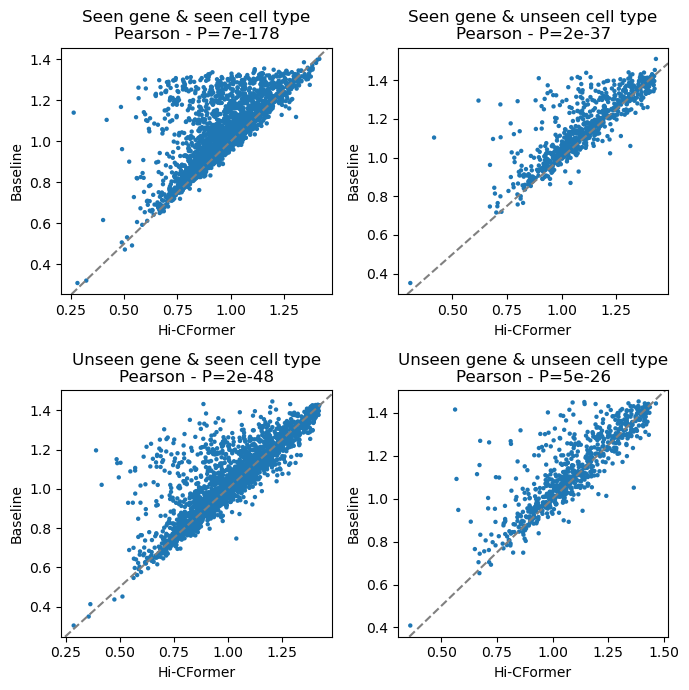

In [12]:
# metric_str = 'pearson'
metric_str = 'mse'
def fn(x, y):
    x = x[..., 80:-80].ravel()
    y = y[..., 80:-80].ravel()
    x = StandardScaler().fit_transform(x[:, None]).squeeze(-1)
    y = StandardScaler().fit_transform(y[:, None]).squeeze(-1)
    if metric_str == 'pearson':
        return pearsonr(x, y)[0]
    elif metric_str == 'mse':
        return np.linalg.norm(x - y, ord=2) / np.sqrt(len(x))
    else:
        raise NotImplemented
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(2, 2, figsize=(7, 7))
    for ax, (cell_type_indices, gene_indices, title) in zip(axes.flat, [
        (seen_cell_type_idx, seen_gene_idx, 'Seen gene & seen cell type'),
        (seen_cell_type_idx, unseen_gene_idx, 'Seen gene & unseen cell type'),
        (unseen_cell_type_idx, seen_gene_idx, 'Unseen gene & seen cell type'),
        (unseen_cell_type_idx, unseen_gene_idx, 'Unseen gene & unseen cell type'),
    ]):
        df = pd.DataFrame({
            'Hi-CFormer': tqdm([fn(
                prediction_hic1d2d[cell_type_indices, gene_idx],
                expression_all[cell_type_indices, gene_idx],
            ) for gene_idx in gene_indices]),
            'Baseline': tqdm([fn(
                prediction_baseline[cell_type_indices, gene_idx],
                expression_all[cell_type_indices, gene_idx],
            ) for gene_idx in gene_indices]),
        })
        x = df.values
        # density = KernelDensity(bandwidth=.2).fit(x).score_samples(x)
        # density = np.exp(density)
        # df['density'] = density
        sns.scatterplot(
            ax=ax, data=df, x='Hi-CFormer', y='Baseline', edgecolor='none',
            s=10,
            # palette='coolwarm', hue='density', 
        )
        ax.axline((.5, .5), slope=1, linestyle='--', color='grey')
        stat, pval = ttest_rel(*list(x.T), alternative='less' if metric_str in ['mse'] else 'greater')
        ax.set(title=f'{title}\nPearson - P={pval:.0e}')
    fig.tight_layout()
    path2file = path2figdir / f'performance_comparison_scatter_{metric_str}.pdf'
    print(path2file)
    plt.savefig(path2file, dpi=600)
    plt.show()
    plt.close('all')

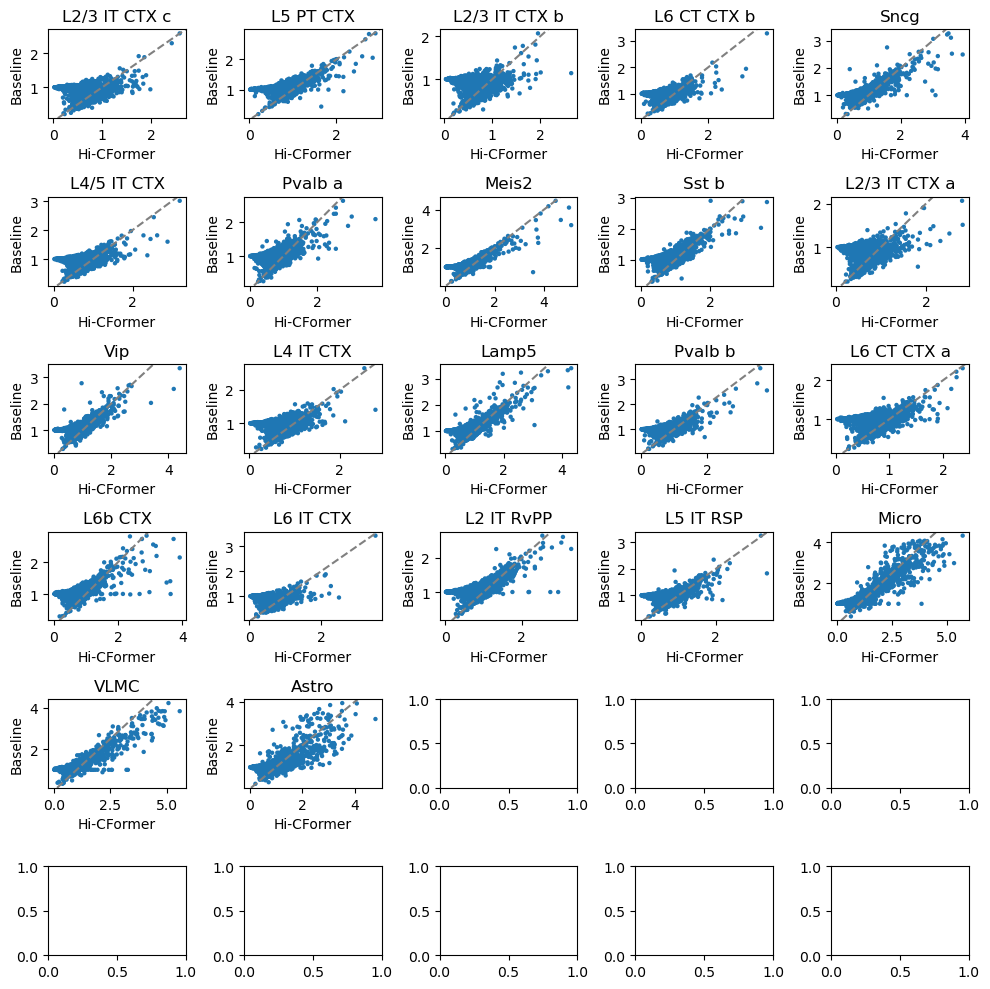

In [91]:
cell_type_indices, gene_indices = seen_cell_type_idx, seen_gene_idx
def normalize(x):
    c, g, l = x.shape
    return StandardScaler().fit_transform(x.transpose(0, 2, 1).reshape(c*l, g))\
        .reshape(c, l, g).transpose(0, 2, 1)
def calc_metric(x, y):
    # return (x * y).mean(-1)
    return np.linalg.norm(x-y, axis=-1, ord=2) / np.sqrt(x.shape[-1])
p_h = normalize(prediction_hic1d2d[cell_type_indices][:, gene_indices, 80:-80])
p_b = normalize(prediction_baseline[cell_type_indices][:, gene_indices, 80:-80])
e = normalize(expression_all[cell_type_indices][:, gene_indices, 80:-80])
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(6, 5, figsize=(10, 10))
    for ax, (cell_type_i, cell_type_idx) in zip(axes.flat, enumerate(cell_type_indices)):
        df = pd.DataFrame({
            'Hi-CFormer': calc_metric(p_h[cell_type_i], e[cell_type_i]),
            'Baseline': calc_metric(p_b[cell_type_i], e[cell_type_i]),
        })
        x = df.values
        # density = KernelDensity(bandwidth=.2).fit(x).score_samples(x)
        # density = np.exp(density)
        # df['density'] = density
        sns.scatterplot(
            ax=ax, data=df, x='Hi-CFormer', y='Baseline', edgecolor='none', s=10,
            # palette='coolwarm', hue='density', 
        )
        ax.axline((.5, .5), slope=1, linestyle='--', color='grey')
        ax.set(title=cell_type_list[cell_type_idx])
        # ax.get_legend().remove()
        # break
    fig.tight_layout()
    plt.show()
    plt.close('all')

../figures-gage-seq-mBC/performance_comparison_scatter_majortype_mse.pdf


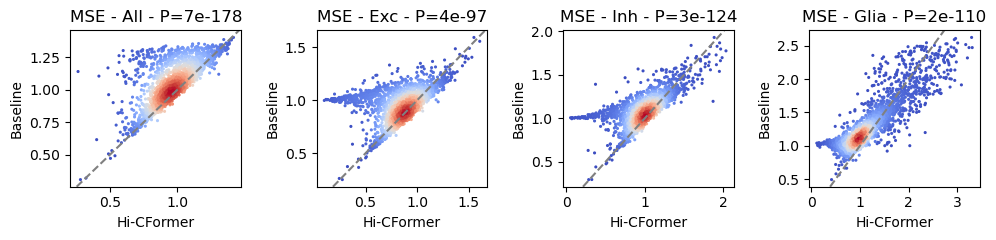

In [13]:
# metric_str = 'pearson'
metric_str = 'mse'
cell_type_indices, gene_indices = seen_cell_type_idx, seen_gene_idx
def normalize(x):
    c, g, l = x.shape
    return StandardScaler().fit_transform(x.transpose(0, 2, 1).reshape(c*l, g))\
        .reshape(c, l, g).transpose(0, 2, 1)
def calc_metric(x, y):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    if metric_str == 'pearson':
        return (x * y).mean(-1)
    elif metric_str == 'mse':
        return np.linalg.norm(x-y, axis=-1, ord=2) / np.sqrt(x.shape[-1])
    else:
        raise NotImplementedError
p_h = normalize(prediction_hic1d2d[cell_type_indices][:, gene_indices, 80:-80])
p_b = normalize(prediction_baseline[cell_type_indices][:, gene_indices, 80:-80])
e = normalize(expression_all[cell_type_indices][:, gene_indices, 80:-80])
cell_type_dict = {
    'All': slice(None),
    'Exc': np.array([c.startswith('L') for c in cell_type_list[cell_type_indices]]),
    'Inh': np.isin(
        cell_type_list[cell_type_indices],
        ['Lamp5', 'Meis2', 'Pvalb a', 'Pvalb b', 'Sncg', 'Sst a', 'Sst b', 'Vip']),
    'Glia': np.isin(
        cell_type_list[cell_type_indices],
        ['Astro', 'Micro', 'ODC', 'OPC', 'VLMC']),
}
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
    for ax, (cell_type_name, cell_type_mask) in zip(axes.flat, cell_type_dict.items()):
        df = pd.DataFrame({
            'Hi-CFormer': calc_metric(p_h[cell_type_mask], e[cell_type_mask]),
            'Baseline': calc_metric(p_b[cell_type_mask], e[cell_type_mask]),
        })
        x = df.values
        density = KernelDensity(bandwidth=.1).fit(x).score_samples(x)
        density = np.exp(density)
        df['density'] = density
        sns.scatterplot(
            ax=ax, data=df, x='Hi-CFormer', y='Baseline', edgecolor='none',
            s=5,
            palette='coolwarm', hue='density',
        )
        ax.axline((.5, .5), slope=1, linestyle='--', color='grey')
        stat, pval = ttest_rel(*list(x.T), alternative='less')
        ax.set(title=f'MSE - {cell_type_name} - P={pval:.0e}')
        ax.get_legend().remove()
        # break
    fig.tight_layout()
    path2file = path2figdir / f'performance_comparison_scatter_majortype_{metric_str}.pdf'
    print(path2file)
    plt.savefig(path2file, dpi=600)
    plt.show()
    plt.close('all')

In [62]:
metric_str = 'pearson'
# metric_str = 'mse'
def normalize(x):
    if metric_str == 'pearson':
        return x
    else:
        c, g, l = x.shape
        return StandardScaler().fit_transform(x.transpose(0, 2, 1).reshape(c*l, g))\
            .reshape(c, l, g).transpose(0, 2, 1)
def calc_metric(x, y):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    if metric_str == 'pearson':
        # return (x * y).mean(-1)
        return np.array([pearsonr(x.ravel(), y.ravel())[0]])
    elif metric_str == 'mse':
        return np.linalg.norm(x-y, axis=-1, ord=2) / np.sqrt(x.shape[-1])
    else:
        raise NotImplementedError
df = pd.DataFrame([
    dict(
        # dataset=dataset,
        dataset=dataset.replace(' & s', '\nS').replace(' & u', '\nU'),
        algorithm=algo,
        score=calc_metric(p, e).mean(),
    )
    for cell_type_indices, gene_indices, dataset in [
        (seen_cell_type_idx, seen_gene_idx, 'Seen gene & seen cell type'),
        (unseen_cell_type_idx, seen_gene_idx, 'Unseen gene & seen cell type'),
        (seen_cell_type_idx, unseen_gene_idx, 'Seen gene & unseen cell type'),
        (unseen_cell_type_idx, unseen_gene_idx, 'Unseen gene & unseen cell type'),
    ]
    for p, e, algo in [
        (
            normalize(prediction_hic1d2d[cell_type_indices][:, gene_indices, 80:-80]),
            normalize(expression_all[cell_type_indices][:, gene_indices, 80:-80]),
            'Hi-CFormer'),
        (
            normalize(prediction_hic2d[cell_type_indices][:, gene_indices, 80:-80]),
            normalize(expression_all[cell_type_indices][:, gene_indices, 80:-80]),
            'Hi-CFormer (2D-only)'),
        (
            normalize(prediction_hic1d[cell_type_indices][:, gene_indices, 80:-80]),
            normalize(expression_all[cell_type_indices][:, gene_indices, 80:-80]),
            'Hi-CFormer (1D-only)'),
        (
            normalize(prediction_baseline[cell_type_indices][:, gene_indices, 80:-80]),
            normalize(expression_all[cell_type_indices][:, gene_indices, 80:-80]),
            'Baseline'),
    ]
]).rename(columns={'score': metric_str})

../figures-gage-seq-mBC/performance_comparison_bar_pearson.pdf


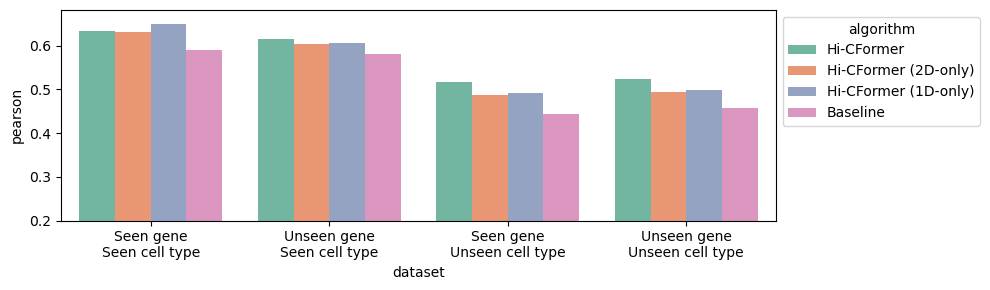

In [63]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.barplot(
        ax=ax, data=df, x='dataset', y=metric_str, hue='algorithm',
        palette='Set2',
    )
    sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim(.2, ax.get_ylim()[1])
    fig.tight_layout()
    path2file = path2figdir / f'performance_comparison_bar_{metric_str}.pdf'
    print(path2file)
    plt.savefig(path2file, dpi=600)
    plt.show()
    plt.close('all')

# TFBS

In [145]:
df_meta_gene.head(5)

,gene_id,chrom,pos,strand
0,ENSMUSG00000000001,mm10_chr3,108146146,-
1,ENSMUSG00000000127,mm10_chr17,63863062,+
2,ENSMUSG00000000131,mm10_chr7,126200501,-
3,ENSMUSG00000000142,mm10_chr11,108920349,+
4,ENSMUSG00000000149,mm10_chr5,140830431,-


In [146]:
path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/tfbs')
df_tfbs = pd.read_csv(path2dir / 'hit_r1000_dboth_thr0.csv.gz')
df_tfbs.head(5)

,gene_id,tf_name,hit
0,ENSMUSG00000002459,MA0002.2,1
1,ENSMUSG00000002459,MA0035.1,1
2,ENSMUSG00000002459,MA0035.2,1
3,ENSMUSG00000002459,MA0035.3,1
4,ENSMUSG00000002459,MA0037.4,1


In [147]:
def calc_metric(x, y):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    return np.array([pearsonr(*_)[0] for _ in zip(x, y)])
cell_type_indices, gene_indices = seen_cell_type_idx, seen_gene_idx
p_h = prediction_hic1d2d[cell_type_indices][:, gene_indices][..., 80:-80]
p_b = prediction_baseline[cell_type_indices][:, gene_indices][..., 80:-80]
e = expression_all[cell_type_indices][:, gene_indices][..., 80:-80]
df = pd.DataFrame({
    'Hi-CFormer': calc_metric(p_h, e),
    'Baseline': calc_metric(p_b, e),
    'gene_id': df_meta_gene.gene_id[gene_indices].values,
}).set_index('gene_id')
df['n_tfbs'] = df_tfbs.groupby('gene_id').hit.sum()
df_score = df
df

,Hi-CFormer,Baseline,n_tfbs
gene_id,,,
ENSMUSG00000000001,0.508994,0.498985,336
ENSMUSG00000000127,0.537531,0.549553,72
ENSMUSG00000000131,0.532201,0.532826,248
ENSMUSG00000000142,0.553744,0.494280,115
ENSMUSG00000000149,0.477459,0.432584,262
...,...,...,...
ENSMUSG00000057375,0.399208,0.391167,285
ENSMUSG00000057409,0.436265,0.463075,224
ENSMUSG00000057440,0.175051,0.194643,123


../figures-gage-seq-mBC/performance_explanation_box_tfbs.pdf


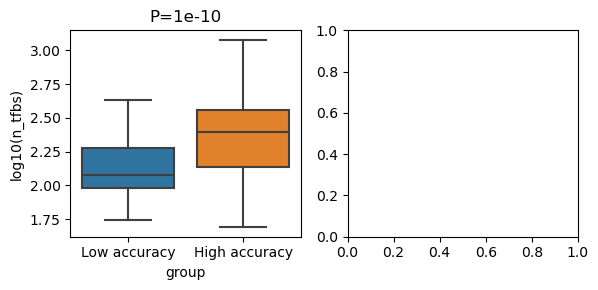

In [148]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes_iter = iter(axes.flat)

    ax = next(axes_iter)
    df = df_score.copy()
    mask1 = (df['Hi-CFormer'] - df['Baseline'] < .2) & df[['Hi-CFormer', 'Baseline']].min(1).ge(.6)
    mask2 = (df['Hi-CFormer'] - df['Baseline'] < .2) & df[['Hi-CFormer', 'Baseline']].max(1).le(.2)
    assert ~(mask1 & mask2).any()
    df['group'] = np.where(mask1, 'High accuracy', np.where(mask2, 'Low accuracy', 'Other'))
    df = df[df.group.ne('Other')]
    df['log10(n_tfbs)'] = np.log10(df.n_tfbs)
    dfg = df.groupby('group')
    y = 'log10(n_tfbs)'
    stat, pval = ttest_ind(df.loc[mask1, y], df.loc[mask2, y])
    sns.boxplot(ax=ax, data=df, x='group', y=y)
    ax.set_title(f'P={pval:.0e}')

fig.tight_layout()
path2file = path2figdir / f'performance_explanation_box_tfbs.pdf'
print(path2file)
plt.savefig(path2file, dpi=600)
plt.show()
plt.close('all')

# DEG

In [115]:
path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/DEG-Seurat')
df_deg_dict = dict()
mapping = dict(__[::-1] for _, __ in df_gene_id_conversion.drop_duplicates('gene_name', keep=False).iterrows())
for filename in tqdm(os.listdir(path2dir)):
    df = pd.read_csv(path2dir / filename).rename(columns={'Unnamed: 0': 'gene_name'})
    df['gene_id'] = df.gene_name.apply(mapping.get)
    df = df.dropna()
    df_deg_dict[tuple(filename.split('-')[:2])] = df

  0%|          | 0/270 [00:00<?, ?it/s]

In [118]:
sorted(df_deg_dict.keys())

[('Astro', 'Glia'),
 ('Astro', 'Micro'),
 ('Astro', 'ODC'),
 ('Astro', 'OPC'),
 ('Astro', 'VLMC'),
 ('CT', 'Exc'),
 ('CT', 'L6b'),
 ('CT', 'NP'),
 ('Exc', 'Inh'),
 ('IT', 'CT'),
 ('IT', 'Exc'),
 ('IT', 'L6b'),
 ('IT', 'NP'),
 ('IT', 'PT'),
 ('L23ITCTX', 'Exc'),
 ('L23ITCTX', 'ExcIT'),
 ('L23ITCTX', 'ExcITCTX'),
 ('L23ITCTX', 'L6CTCTX'),
 ('L23ITCTXa', 'Exc'),
 ('L23ITCTXa', 'ExcIT'),
 ('L23ITCTXa', 'ExcITCTX'),
 ('L23ITCTXa', 'L23ITCTX'),
 ('L23ITCTXa', 'L23ITCTXb'),
 ('L23ITCTXa', 'L23ITCTXc'),
 ('L23ITCTXa', 'L45ITCTX'),
 ('L23ITCTXa', 'L4ITCTX'),
 ('L23ITCTXa', 'L56NPCTX'),
 ('L23ITCTXa', 'L5ITCTX'),
 ('L23ITCTXa', 'L5ITRSP'),
 ('L23ITCTXa', 'L5PTCTX'),
 ('L23ITCTXa', 'L6CTCTX'),
 ('L23ITCTXa', 'L6CTCTXa'),
 ('L23ITCTXa', 'L6CTCTXb'),
 ('L23ITCTXa', 'L6ITCTX'),
 ('L23ITCTXa', 'L6bCTX'),
 ('L23ITCTXb', 'Exc'),
 ('L23ITCTXb', 'ExcIT'),
 ('L23ITCTXb', 'ExcITCTX'),
 ('L23ITCTXb', 'L23ITCTX'),
 ('L23ITCTXb', 'L23ITCTXc'),
 ('L23ITCTXb', 'L45ITCTX'),
 ('L23ITCTXb', 'L4ITCTX'),
 ('L23ITCTX

In [116]:
df_deg_dict['Exc', 'Inh']

,gene_name,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene_id
0,Arpp21,0.0,2.484241,0.995,0.687,0.0,ENSMUSG00000032503
1,Celf2,0.0,2.013495,1.000,0.974,0.0,ENSMUSG00000002107
2,Dpp10,0.0,2.514369,0.998,0.988,0.0,ENSMUSG00000036815
3,Erbb4,0.0,-5.649183,0.501,0.915,0.0,ENSMUSG00000062209
4,Grip1,0.0,-3.475211,0.813,0.982,0.0,ENSMUSG00000034813
...,...,...,...,...,...,...,...
17014,Rasal3,1.0,0.000000,0.000,0.000,1.0,ENSMUSG00000052142
17015,Slc11a1,1.0,0.000000,0.000,0.000,1.0,ENSMUSG00000026177
17016,Slc35d2,1.0,0.000000,0.000,0.000,1.0,ENSMUSG00000033114
17017,Slfn8,1.0,0.000000,0.000,0.000,1.0,ENSMUSG00000035208


In [119]:
def calc_metric(x, y):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    return np.array([pearsonr(*_)[0] for _ in zip(x, y)])
cell_type_indices, gene_indices = seen_cell_type_idx, seen_gene_idx
p_h = prediction_hic1d2d[cell_type_indices][:, gene_indices][..., 80:-80]
p_b = prediction_baseline[cell_type_indices][:, gene_indices][..., 80:-80]
e = expression_all[cell_type_indices][:, gene_indices][..., 80:-80]
df = pd.DataFrame({
    'Hi-CFormer': calc_metric(p_h, e),
    'Baseline': calc_metric(p_b, e),
    'gene_id': df_meta_gene.gene_id[gene_indices].values,
}).set_index('gene_id')
df_score = df
df

,Hi-CFormer,Baseline
gene_id,,
ENSMUSG00000000001,0.508994,0.498985
ENSMUSG00000000127,0.537531,0.549553
ENSMUSG00000000131,0.532201,0.532826
ENSMUSG00000000142,0.553744,0.494280
ENSMUSG00000000149,0.477459,0.432584
...,...,...
ENSMUSG00000057375,0.399208,0.391167
ENSMUSG00000057409,0.436265,0.463075
ENSMUSG00000057440,0.175051,0.194643


../figures-gage-seq-mBC/performance_explanation_box_deg.pdf


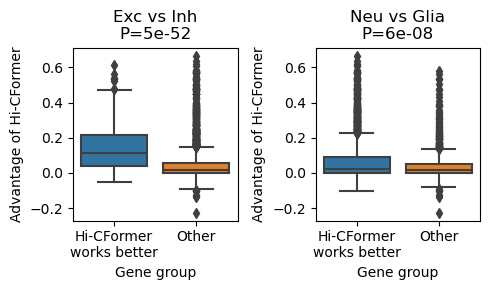

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
for ax, deg_key in zip(axes.flat, [
    ('Exc', 'Inh'),
    ('Neu', 'Glia'),
]):
    df = df_deg_dict[deg_key].copy()
    df = df[df.p_val_adj.le(1e-3)]
    gene_ids = df.gene_id.values
    df = df_score.reset_index().copy()
    y = 'Advantage of Hi-CFormer'
    df[y] = df['Hi-CFormer'] - df['Baseline']
    df['group'] = np.where(
        df.gene_id.isin(gene_ids),
        'DEG',
        'Other',
    )
    df.group = pd.Categorical(df.group, categories=np.unique(df.group))
    df['Gene group'] = df.group
    mask = df.group.eq('Other')
    stat, pval = ttest_ind(df.loc[~mask, y], df.loc[mask, y])
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        sns.boxplot(ax=ax, data=df, x='Gene group', y=y)
    ax.set_title(f'{deg_key[0]} vs {deg_key[1]}\nP={pval:.0e}')
    # ax.tick_params('x', rotation=45)

fig.tight_layout()
path2file = path2figdir / f'performance_explanation_box_deg.pdf'
print(path2file)
plt.savefig(path2file, dpi=600)
plt.show()
plt.close('all')

# GO